<a href="https://colab.research.google.com/github/juliolunamoreno/KNN/blob/master/Kaggle_Analysis_on_movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
import os
import codecs
from sklearn import feature_extraction
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords as sw
from google.colab import files
from IPython.display import Image
import re
from nltk.stem import PorterStemmer,LancasterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.probability import FreqDist


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Funciones para analisis y modelado

In [0]:
def Descriptiva(df,col):
  freq=df[col].value_counts(normalize=False)
  pct=df[col].value_counts(normalize=True)
  accum_freq=df[col].value_counts(normalize=False).cumsum()
  accum_pct=df[col].value_counts(normalize=True).cumsum()
  tabla=pd.DataFrame({'Freq':freq,
                      'Pct':pct,'Accum_Freq':accum_freq,'Accum_Pct':accum_pct}).reindex(['Freq','Pct',
                                                                                         'Accum_Freq','Accum_Pct'],axis=1)
  return tabla

In [0]:
def Benchmark(models,X,y,scoring='roc_auc',cv=3):
  names,roc,cv_min,cv_max,cv_score=[],[],[],[],[]
  
  for model in models:
    names.append(str(model)[:str(model).find('(')])
  
  for model in models:
    model.fit(X,y)
    cv_score.append(np.mean(cross_val_score(X=X,y=y,estimator=model,scoring=scoring,cv=cv)))
    cv_min.append(np.min(cross_val_score(X=X,y=y,estimator=model,scoring=scoring,cv=cv)))
    cv_max.append(np.max(cross_val_score(X=X,y=y,estimator=model,scoring=scoring,cv=cv)))
  resultados=pd.DataFrame(data={'CV Score':cv_score,'CV Min':cv_min,'CV max':cv_max},index=names)
  resultados.plot.barh(figsize=(12,7))
  return resultados


In [0]:
def ROCs(models,X,y,test_size=.3):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size)
    ls=[]
    names=[]
    
    for model in models:
        names.append(str(model)[:str(model).find('(')])
    
    plt.figure(figsize=(12,7))
    for name,model in zip(names,models):
        model.fit(X_train,y_train)
        escore=roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
        fpr,tpr,thresshold=roc_curve(y_test,model.predict_proba(X_test)[:,1])
        ls.append(escore)
        plt.plot(fpr,tpr,label=name+ ': '+ str(round(escore,4)))
    plt.plot([0,1],[0,1],'--',color='red',label='Threshold')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc='best')

In [151]:
updated=files.upload()

Saving sentiment_train.tsv to sentiment_train (1).tsv


In [0]:
df=pd.read_csv('sentiment_train.tsv',sep='\t')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


# Analisis descriptivo

In [0]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [0]:
df.groupby(['SentenceId'])['Phrase'].count().nlargest(25)

SentenceId
1       63
5555    63
509     59
625     58
403     57
22      56
149     56
240     55
128     54
817     54
7705    54
82      53
301     53
2124    53
595     52
654     52
217     51
635     51
3023    51
3635    51
113     50
152     50
293     50
1032    50
4563    50
Name: Phrase, dtype: int64

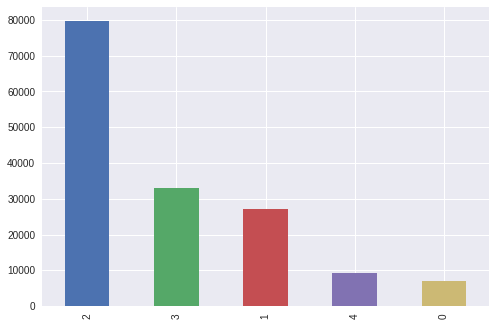

In [0]:
df.Sentiment.value_counts().plot.bar()

In [0]:
Descriptiva(df,'Sentiment')

,Freq,Pct,Accum_Freq,Accum_Pct
2,79582,0.509945,79582,0.509945
3,32927,0.210989,112509,0.720934
1,27273,0.174760,139782,0.895694
4,9206,0.058990,148988,0.954684
0,7072,0.045316,156060,1.000000


In [0]:
punctuation=[',','.','""','!','?','¿','¡',"'","n't","'s",'``','--','`','.is',".'s",'I','The','...',"''"]
palabras=df.Phrase.tolist()
palabras= ''.join(palabras)
palabras=palabras.split()
stopwords=nltk.corpus.stopwords.words('english')
palabras=[pal for pal in palabras if pal not in stopwords]
palabras=[pal for pal in palabras if pal not in punctuation]

In [0]:
freq=nltk.FreqDist(palabras)

In [0]:
freq.most_common(10)

[('film', 4943),
 ('movie', 4310),
 ('one', 2503),
 ('like', 2339),
 ('story', 1665),
 ('good', 1608),
 ('much', 1541),
 ('-RRB-', 1514),
 ('-LRB-', 1467),
 ('characters', 1321)]

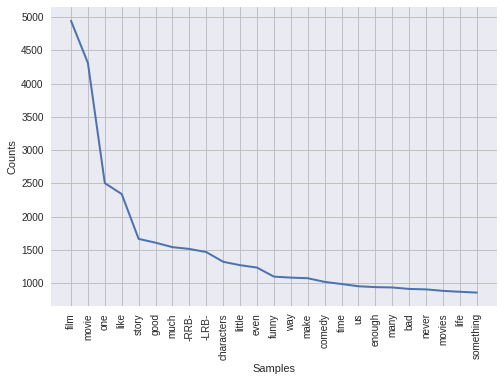

In [0]:
freq.plot(25)

In [0]:
nltk.download('stopwords')
texto=df.Phrase.to_string().lower()
stopwords=sw.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(-0.5, 399.5, 199.5, -0.5)

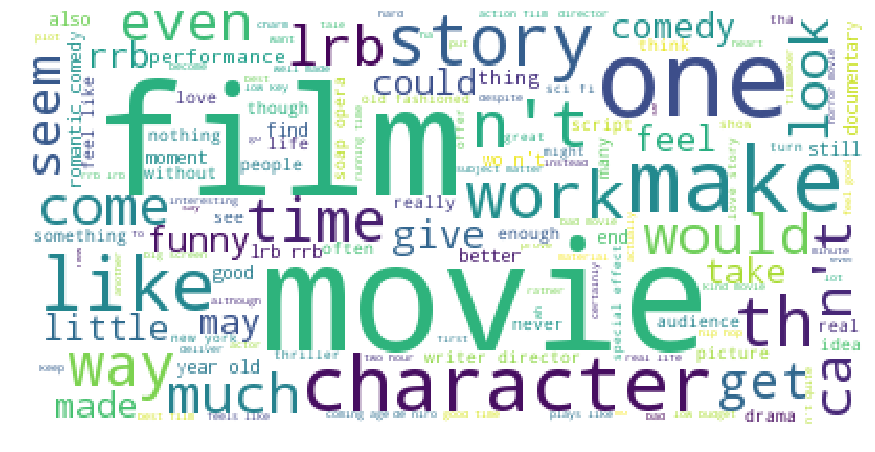

In [0]:
wordcloud=WordCloud(stopwords=stopwords,background_color='white')
wordcloud.generate(texto)
plt.figure(figsize=(15,11))
plt.imshow(wordcloud)
plt.axis('off')

# Text clustering

In [0]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.cluster import MiniBatchKMeans,DBSCAN
from sklearn.preprocessing import MaxAbsScaler

In [0]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',tokenizer=token.tokenize,ngram_range=(1,1))
tdidf=TfidfVectorizer(tokenizer=token.tokenize,stop_words='english',ngram_range=(1,4))
text_counts= cv.fit_transform(df['Phrase'])
text_tdidf=tdidf.fit_transform(df['Phrase'])
y=df.Sentiment

### Número optimo de clusters K Means

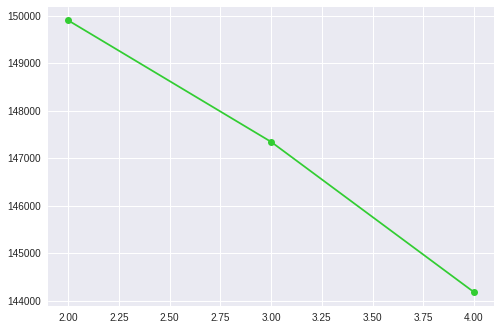

In [0]:
ls=[]
for k in range(2,5):
  kmeans=MiniBatchKMeans(n_clusters=k,random_state=0).fit(text_tdidf)
  ls.append(kmeans.inertia_)
plt.plot(range(2,5),ls,marker='o',color='limegreen')
  

In [0]:
df['cluster']=MiniBatchKMeans(n_clusters=4,random_state=0).fit(text_tdidf).labels_

In [0]:
df.cluster.value_counts()

0    116392
2     20419
1     10751
3      8498
Name: cluster, dtype: int64

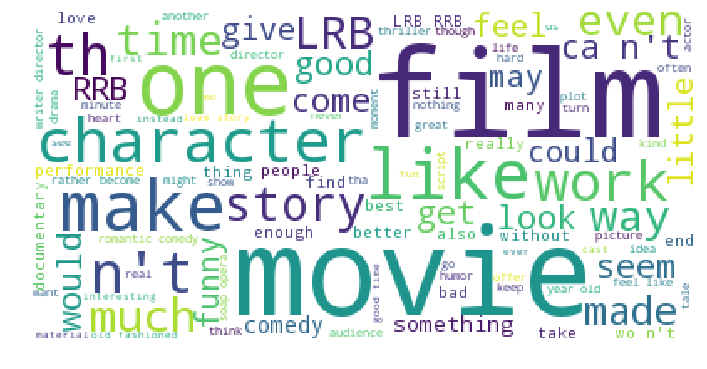

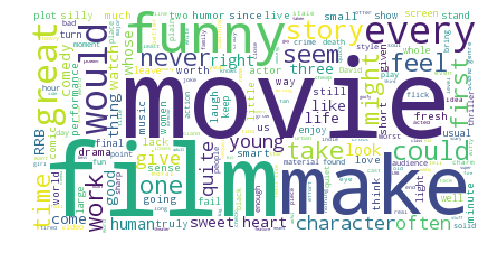

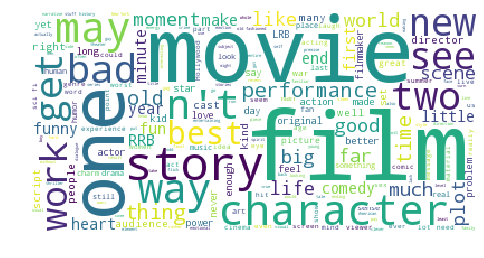

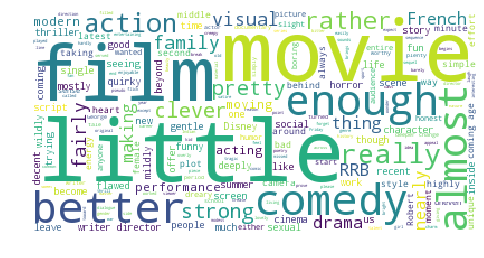

In [0]:
plt.figure(figsize=(12,7))
for i in range(4):
  texto=df[df.cluster==i]['Phrase'].to_string()
  wc=WordCloud(stopwords=stopwords,background_color='white').generate(texto)
  plt.imshow(wc)
  plt.axis('off')
  plt.show()
  

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score,roc_curve

# Modelo 1 : BoW

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

CPU times: user 4.42 s, sys: 34.1 ms, total: 4.45 s
Wall time: 4.47 s


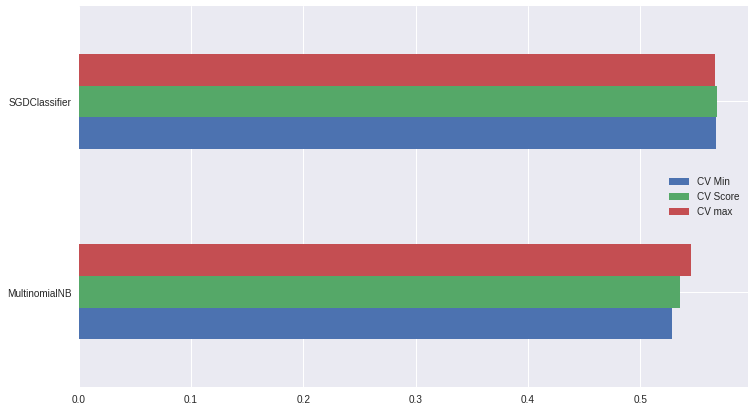

In [0]:
%%time
models=[MultinomialNB(),SGDClassifier(loss='hinge',penalty='l2')]
resultados=Benchmark(models,text_counts,y,'accuracy',cv=3)

In [0]:
resultados

,CV Min,CV Score,CV max
MultinomialNB,0.527855,0.535730,0.545442
SGDClassifier,0.567669,0.567897,0.566703


# Modelo II : Tdi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

CPU times: user 6.65 s, sys: 60.7 ms, total: 6.71 s
Wall time: 6.71 s


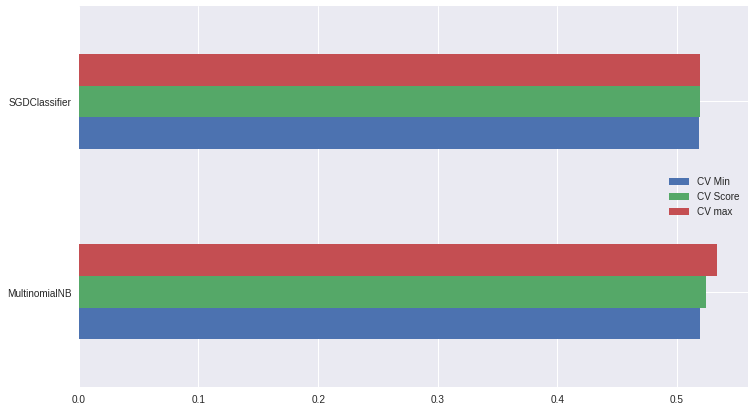

In [0]:
%%time
models=[MultinomialNB(),SGDClassifier(loss='hinge',penalty='l2')]
resultados=Benchmark(models,text_tdidf,y,'accuracy',cv=3)

In [0]:
resultados

,CV Min,CV Score,CV max
MultinomialNB,0.519185,0.524542,0.532967
SGDClassifier,0.518358,0.518749,0.519223
